In [3]:
import glob
import os
import numpy as np
import pandas as pd
import seaborn as sns
import joblib
import dill
import dask, dask_ml
import dask.dataframe as dd

from importlib import reload
from scipy import signal, stats
from tqdm.auto import tqdm
from sklearn import neighbors, linear_model, ensemble, decomposition #svm, neural_network
from sklearn import feature_selection, model_selection, metrics, dummy, pipeline, preprocessing, compose
from dask_ml.model_selection import RandomizedSearchCV
from matplotlib import pyplot as plt
from src import main, feature_model
from itertools import product

In [4]:
from dask_jobqueue import SLURMCluster
from distributed import Client, LocalCluster

In [7]:
try:
    cluster.close()
    client.close()
except NameError:
    pass
finally:
    cluster = SLURMCluster(queue='short', 
                           cores=4, 
                           memory='18gB', 
                           walltime='4:00:00', 
                           death_timeout=60, 
                          )
#                            job_extra=['--exclude=/home/hy180/notibnodes'])
    client = Client(cluster)
    cluster.adapt(minimum=0, maximum=200, wait_count=5)

# Load data

In [9]:
dataset = 'real_phone-tsfeatures'
features_df = pd.read_parquet(f'/home/hy180/projects/beat_pd/extracted_features/{dataset}.parquet') #.set_index(['samp_id', 'id'])

label_cols = ['on_off', 'dyskinesia', 'tremor', 'subject_id']
labels = pd.concat([
    pd.read_csv('/home/hy180/projects/beat_pd/data/cis-pd/data_labels/CIS-PD_Training_Data_IDs_Labels.csv'),
    pd.read_csv('/home/hy180/projects/beat_pd/data/real-pd/data_labels/REAL-PD_Training_Data_IDs_Labels.csv'),
], axis=0).astype({'subject_id': str})

In [ ]:
# These features don't compute for a number of observations
drop_cols = ['rms__friedrich_coefficients__m_3__r_30__coeff_0',
       'rms__friedrich_coefficients__m_3__r_30__coeff_1',
       'rms__friedrich_coefficients__m_3__r_30__coeff_2',
       'rms__friedrich_coefficients__m_3__r_30__coeff_3',
       'rms__max_langevin_fixed_point__m_3__r_30']
# These fft features are null for our size of windows
null_fft_cols = ['rms__fft_coefficient__coeff_%d__attr_"%s"' % (n, s) 
                     for n, s in product(range(51, 100), ['abs', 'angle', 'imag', 'real'])]
# Sample entropy can take inf which screws with models
inf_cols = ['rms__sample_entropy']
df = features_df.drop(columns=[*drop_cols, *null_fft_cols, *inf_cols]).dropna().merge(labels, right_on='measurement_id', left_on='samp_id')
print('%d rows dropped due to nans in features' % (features_df.shape[0] - df.shape[0]).compute())

In [36]:
label = 'tremor'

id_cols = ['measurement_id', 'samp_id']
labeled_samps = df.dropna(subset=[label])

y = df.loc[labeled_samps.index, label].astype('int')
X = labeled_samps.drop(columns=[*label_cols, *id_cols])

# Model

## Model spec

In [39]:
scaler = preprocessing.RobustScaler(quantile_range=(1, 99))
scaler_pg = {'scaler__quantile_range': [(.1, 99.9), (.5, 99.5), (1, 99), (5, 95), (10, 90)],}
# scaler = preprocessing.MinMaxScaler()

# Keep features w/ variance in top 95%ile 
var = lambda X, y: np.var(X, axis=0)
f_select = feature_selection.SelectPercentile(var, percentile=95)
# f_select_pg = {'f_select__percentile': [95, 80, 50, 25, 10],}
f_select_pg = {'f_select__percentile': stats.uniform(0, 100)}
# f_select = feature_selection.SelectKBest(feature_selection.mutual_info_regression, k=30)

# model = linear_model.Ridge()
# model_pg = {'model__regressor__alpha': [0.1, 0.5, 1, 2, 5],}
# model = svm.SVR()
# model_pg = {'model__regressor__kernel': ['linear', 'poly', 'rbf', 'sigmoid'], 'model__regressor__C': stats.chi2(df=2)}
# model = linear_model.ElasticNet()
# model_pg = {'model__regressor__l1_ratio': stats.uniform(0, 1), 'model__regressor__alpha': stats.chi2(df=2), }
# model_pg = {'model__regressor__l1_ratio': [0.01, 0.1, 0.5, 0.8, 0.99], 'model__regressor__alpha': [0.1, 0.5, 1, 2, 5],}
# model = mord.OrdinalRidge()
# model_pg = {'model__regressor__alpha': stats.chi2(df=2), }
model = ensemble.RandomForestRegressor()
model_pg = {'model__regressor__n_estimators': stats.randint(50, 100), 'model__regressor__max_depth': stats.randint(10, 25), 'model__regressor__max_features': [.25, 'auto']}
# model = neural_network.MLPRegressor(learning_rate='adaptive')
# model_pg = {'model__regressor__hidden_layer_sizes': [(100), (50, 50)]}

clip_out = preprocessing.FunctionTransformer(np.clip, kw_args={'a_min': 0, 'a_max': 4})
clipped_model = compose.TransformedTargetRegressor(regressor=model, inverse_func=clip_out.transform)

pipe = pipeline.Pipeline([
    ('scaler', scaler), 
    ('f_select', f_select), 
    ('model', clipped_model),
], verbose=1)

param_grid = {
    **scaler_pg,
    **f_select_pg,
    **model_pg,
}

metric = metrics.make_scorer(metrics.mean_squared_error, greater_is_better=False)

cv = model_selection.StratifiedKFold(shuffle=True)
search = RandomizedSearchCV(pipe, param_grid, n_iter=100, scoring=metric, cv=cv, refit=False, scheduler=client)

## Model eval

In [ ]:
for label in ['dyskinesia', 'on_off', 'tremor']:
    print(f'working on {label}')

    id_cols = ['measurement_id', 'samp_id']
    labeled_samps = df.dropna(subset=[label])

    y = df.loc[labeled_samps.index, label].astype('int')
    X = labeled_samps.drop(columns=[*label_cols, *id_cols])

    X_p, y_p = client.persist([X, y])

    search = RandomizedSearchCV(pipe, param_grid, n_iter=100, scoring=metric, cv=cv, refit=False, scheduler=client)
    cv_fit = search.fit(X, y)
    cv_results = pd.DataFrame(cv_fit.cv_results_)

    resultset_name = f'{dataset}_{type(model).__name__}_{label}'
    cv_results.to_csv(f'performance/cv_paramsweeps/{resultset_name}.csv')
    win_params = cv_results.loc[cv_results.rank_test_score == 1, 'params'].values[0]
    winner = pipe.set_params(**win_params)
    with open(f'models/paramsweep_winners/{resultset_name}.model', 'wb') as f:
        dill.dump(winner, f)
    print(f'done with {label}')
    

    cluster = SLURMCluster(queue='short', 
                           cores=4, 
                           memory='28gB', 
                           walltime='4:00:00', 
                           death_timeout=60, 
                          )
    client = Client(cluster)
    cluster.adapt(minimum=0, maximum=200, wait_count=20)

### Dask debugging 

In [ ]:
# Pull up erring key
err = client.futures["('score-b0e3729a01d6f20aec7498c297e3c3b1', 24, 2)"]
key, err = client.futures.popitem()
# keys, states = [*zip(*[*client.futures.items()])]

In [ ]:
import traceback as tb
tb.print_tb(err.traceback)
print(err.exception)

## Single train-test split for evaluation

In [40]:
import ast

cv_results = pd.read_csv(f'performance/cv_paramsweeps/{dataset}_{type(model).__name__}_{label}.csv')
win_params = ast.literal_eval(cv_results.loc[cv_results.rank_test_score == 1, 'params'].values[0])
winner = pipe.set_params(**win_params)

In [41]:
X_c = X.reset_index(drop=True)
y_c = y.reset_index(drop=True)
samp_map = labeled_samps.loc[:, 'samp_id'].reset_index(drop=True)

x_train, x_test, y_train, y_test = model_selection.train_test_split(X_c, y_c, test_size=.25, stratify=y_c)

[Pipeline] ............ (step 1 of 3) Processing scaler, total=   1.2s
[Pipeline] .......... (step 2 of 3) Processing f_select, total=   0.3s
[Pipeline] ............. (step 3 of 3) Processing model, total= 4.9min


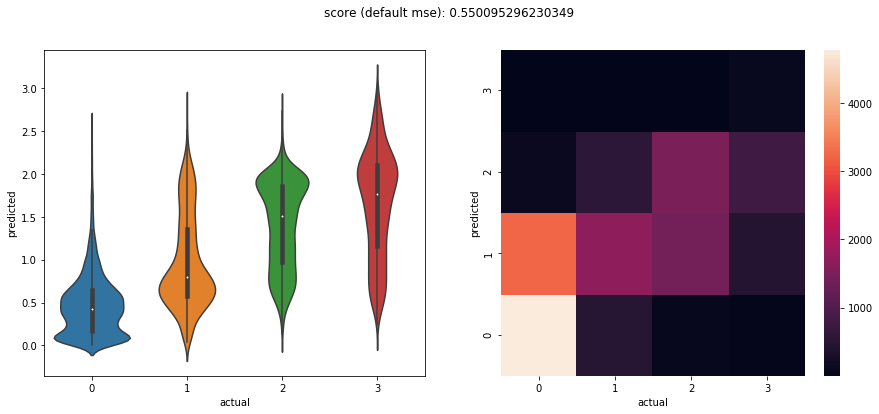

In [43]:
with joblib.parallel_backend('loky'):
    winner.fit(x_train, y_train)
    pred = winner.predict(x_test)

main.plot_performance(y_test, pred)

In [44]:
pd.Series(data=winner.named_steps['model'].regressor_.feature_importances_,
          index=X.columns[winner.named_steps['f_select'].get_support()]).sort_values().iloc[-20:]

id                                                                 0.009095
rms__minimum                                                       0.009106
rms__quantile__q_0.8                                               0.009744
rms__autocorrelation__lag_5                                        0.009759
rms__agg_linear_trend__f_agg_"mean"__chunk_len_5__attr_"stderr"    0.010161
rms__fft_coefficient__coeff_0__attr_"abs"                          0.010171
rms__time_reversal_asymmetry_statistic__lag_1                      0.010728
rms__sum_values                                                    0.011315
rms__quantile__q_0.7                                               0.011363
rms__partial_autocorrelation__lag_2                                0.011414
rms__mean                                                          0.011487
rms__autocorrelation__lag_2                                        0.012906
rms__range_count__max_1000000000000.0__min_0                       0.014896
rms__quantil

###  Combine window predictions using mean

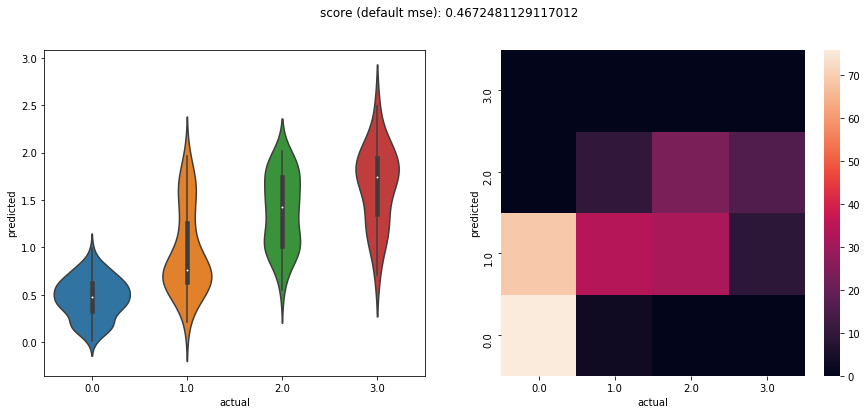

In [45]:
# Ensemble prediction by taking mean of window predictions 
ensem_pred = pd.DataFrame({'samp_id': samp_map[y_test.index], 'pred': pred}).groupby('samp_id').mean()
result = ensem_pred.join(labels.loc[labels.measurement_id.isin(ensem_pred.index)].set_index('measurement_id')[label])
main.plot_performance(result[label], result.pred)

#### Look at range of predictions on single observation

Text(0.5, 1.0, '03ca8369-bf89-49e9-a667-c4bc32b35a09 actual: 3.0')

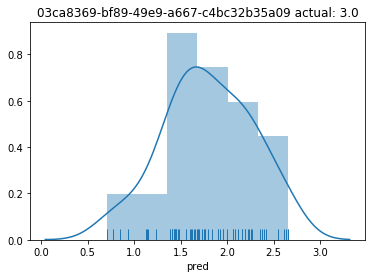

In [217]:
# Look at single 
s = samp_map.sample().values[0]
d = pd.DataFrame({'samp_id': samp_map[y_test.index], 'pred': pred})
ax = sns.distplot(d[d.samp_id == s].pred, rug=True)
ax.set_title(f'{s} actual: {labels[labels.measurement_id == s][label].values[0]}')

In [179]:
samp_map.value_counts()

89acf665-fe65-4251-bb91-1f5dbf7b4c6a    238
9446b6f3-6c09-4366-8b60-ac3d10387880    238
d44b61dc-6440-4b80-adb7-488104fa7cbe    238
fb82d4fa-d118-4d5b-ae61-46bfdfb91247    238
7a5aaf70-b362-4cab-8ad2-10a5edfc4a39    238
                                       ... 
b5098d2c-fdec-485c-a855-bd5cd7ff68ea     31
92a5282f-27d2-4608-9e23-cfe3ac6863df     30
b4b4486b-ecfb-43a9-a09f-0e1f613b161c     29
6e412bc6-0861-48c3-875d-c7b2e5edafc9     21
2559e082-f3c1-4824-808f-a9c3eb4a8fe5      1
Name: samp_id, Length: 274, dtype: int64

In [224]:
np.percentile(d[d.samp_id == s].pred, [25, 75])

array([1.44505415, 2.16233382])

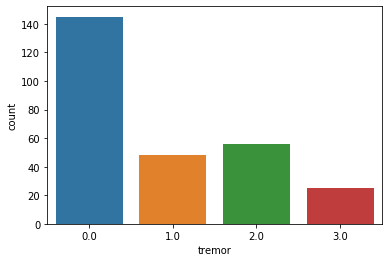

In [171]:
sns.countplot(labels[labels.measurement_id.isin(samp_map.unique())][label])

# Baseline for reference

In [18]:
# label = 'dyskinesia'
labeled_samps = df.dropna(subset=[label]).drop(columns=[*label_cols, *id_cols])

y = df.loc[labeled_samps.index, label].astype('int')
metric = metrics.make_scorer(metrics.mean_squared_error, greater_is_better=False)

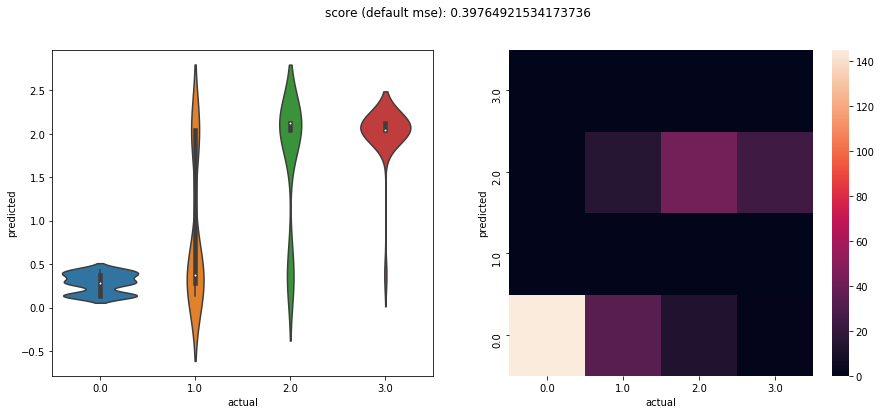

In [24]:
# patient-specific mean predictor
subj_means = labels.groupby('subject_id').mean()
X_subjs = labels[labels.measurement_id.isin(samp_map.unique())][['subject_id']]
actuals = labels[labels.measurement_id.isin(samp_map.unique())][label]
naive_pred = X_subjs.merge(subj_means[[label]], left_on='subject_id', right_index=True).rename(columns={label: 'prediction'})
main.plot_performance(actuals, naive_pred.prediction)

# Predictions on test set

In [ ]:
import ast

cv_results = pd.read_csv(f'performance/cv_paramsweeps/{dataset}_{type(model).__name__}_{label}.csv')
win_params = ast.literal_eval(cv_results.loc[cv_results.rank_test_score == 1, 'params'].values[0])
winner = pipe.set_params(**win_params)

In [ ]:
test_index = pd.read_csv(f'test_predictions/sub_template_{label}.csv', index_col=0).index
test_features_df = pd.concat([
    pd.read_csv('extracted_features/tsfeatures_cis_test.csv', index_col=0), 
    pd.read_csv('extracted_features/tsfeatures_real_test.csv', index_col=0)
]).drop(columns=drop_cols).reindex(test_index)

test_subjs = pd.concat([
    pd.read_csv('data/test_set/cis-pd/cis-pd.CIS-PD_Test_Data_IDs.csv', index_col=0), 
    pd.read_csv('data/test_set/real-pd/real-pd.REAL-PD_Test_Data_IDs.csv', index_col=0)
]).reindex(test_index)

In [ ]:
# Predict patient-specific mean if data not available
nodata_obs = test_subjs.loc[test_features_df[test_features_df.isna().sum(axis=1) > 0].index]
nodata_predictions = nodata_obs.join(subj_means, on='subject_id')[[label]].rename({label: 'prediction'}, axis=1)

In [ ]:
X = test_features_df.dropna(axis='index')

test_predictions = winner.predict(X)
test_predictions_df = pd.concat([
    pd.DataFrame(index=X.index, data={'prediction': test_predictions}),
    nodata_predictions,
], axis=0)

In [ ]:
test_predictions_df.to_csv(f'test_predictions/test_predictions_{label}.csv', index=True)

# Dimensionality Reduction

In [ ]:
features_df['ord'] = features_df.groupby(['samp_id']).cumcount()

In [ ]:
features_df.reset_index(inplace=True)
features_df.set_index(['samp_id', 'id'], inplace=True)

In [ ]:
features_df.drop(columns='index', inplace=True)

In [ ]:
valid_samps = labels[['measurement_id', 'dyskinesia']]

In [ ]:
label = 'dyskinesia'

valid_samps = labels.dropna(subset=['dyskinesia'])['measurement_id']
X = features_df[features_df.index.get_level_values('samp_id').isin(valid_samps) & ~np.isinf(features_df).any(axis=1)]#[features_df.ord < 21].groupby(['samp_id', 'ord']).sum().unstack()

In [ ]:
pca = decomposition.PCA(n_components=4)
fut = client.submit(pca.fit_transform, X)

In [ ]:
proj = client.gather(fut)

In [ ]:
y = labels[['measurement_id', label]].set_index('measurement_id').reindex(X.index.get_level_values('samp_id'))

In [ ]:
fig = plt.figure(figsize=(8, 8))
_ = sns.scatterplot(x=proj[:, 0], y=proj[:, 3], hue=y.dyskinesia, legend='full')

In [ ]:
label = 'subject_id'

X = f_select.fit_transform(scaler.fit_transform(labeled_samps), y=y)
pca = decomposition.FastICA(n_components=2)
proj = pca.fit_transform(X)
fig = plt.figure(figsize=(8, 8))
_ = sns.scatterplot(x=proj[:, 0], y=proj[:, 1], hue=df.loc[features.index, label], legend='full')

# Archived cells 

In [ ]:
# Local cluster for debugging
try:
    local_cluster.close()
    local_client.close()
except NameError:
    pass
finally:
    local_cluster = LocalCluster(n_workers=4, threads_per_worker=1, dashboard_address='0.0.0.0:8786')
    local_client = Client(local_cluster)
    local_cluster.adapt(minimum=0, maximum=4)